In [1]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
%cd /content/gdrive/MyDrive/Вышечка/4 курс/автобрея/проект

/content/gdrive/MyDrive/Вышечка/4 курс/автобрея/проект


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.4.0
GPU detected: []


In [4]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)


### Датасет

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [6]:
data = data.fillna(method="ffill")

In [7]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


#### Получаем слова, их номера и теги

In [8]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [9]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [10]:
num_words, num_tags

(35179, 17)

### Инициализируем получаение информации из предложений

In [11]:
class SentanceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentances = [s for s in self.grouped]

In [12]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [13]:
# checking the structure of sentances 
sentances[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Индексы слов и индексы тегов

In [14]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = { t: i for i,t in enumerate(tags)}

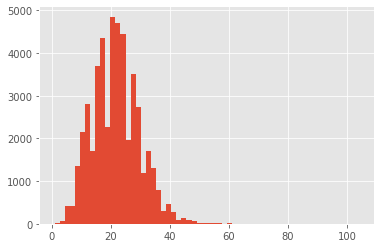

In [15]:
plt.hist([len(s) for s in sentances], bins=60)
plt.show()

### Делаем паддинг и организуем последовательность

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
max_len = 60
X = [[word2idx[w[0]] for w in s] for s in sentances]
X = pad_sequences(maxlen = max_len, sequences =X , padding ='post',value =num_words-1)
y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen=max_len,sequences =y,padding ='post',value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

### Разбиваем на 20 процентов обучающей выборки

In [18]:
X[5000:].shape

(42959, 60)

In [19]:
X[5000:15000].shape

(10000, 60)

In [20]:
x_train = X[5000:]
x_test = X[:5000]
y_train = y[5000:]
y_test = y[:5000]

### Делаем модель с эмбеддингами, лстм и денсом

In [21]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [22]:
input_word = Input(shape = (max_len))
model = Embedding(input_dim = num_words,output_dim = max_len,input_length  = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100,return_sequences=True,recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation ='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 60)            2110740   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 60)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           128800    
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 17)            3417      
Total params: 2,242,957
Trainable params: 2,242,957
Non-trainable params: 0
_________________________________________________________________


### Добавляем оптимизатор адам и запускаем модель

In [23]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=2,verbose = 1, mode ='max',restore_best_weights = True)
callbacks = early_stopping
history = model.fit( x_train,np.array(y_train), validation_split = 0.1, batch_size = 32,epochs = 10, verbose =1,callbacks=callbacks)

Epoch 1/10
1209/1209 [==============================] - 293s 239ms/step - loss: 0.3286 - accuracy: 0.9460 - val_loss: 0.0538 - val_accuracy: 0.9845
Epoch 2/10
1209/1209 [==============================] - 296s 245ms/step - loss: 0.0440 - accuracy: 0.9872 - val_loss: 0.0434 - val_accuracy: 0.9870
Epoch 3/10
1209/1209 [==============================] - 290s 240ms/step - loss: 0.0295 - accuracy: 0.9911 - val_loss: 0.0419 - val_accuracy: 0.9873
Epoch 4/10
1209/1209 [==============================] - 289s 239ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0434 - val_accuracy: 0.9871
Epoch 5/10
1209/1209 [==============================] - 291s 240ms/step - loss: 0.0206 - accuracy: 0.9932 - val_loss: 0.0447 - val_accuracy: 0.9873
Epoch 6/10
1209/1209 [==============================] - 290s 240ms/step - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.0468 - val_accuracy: 0.9870
Epoch 7/10
1209/1209 [==============================] - 289s 239ms/step - loss: 0.0156 - accuracy: 0.9949 - val_

### Результатики

In [26]:
model.evaluate(x_test, np.array(y_test))

157/157 [==============================] - 5s 31ms/step - loss: 0.0465 - accuracy: 0.9868


[0.04654039815068245, 0.9868266582489014]

In [27]:
print('\nhistory dict:', history.history)


history dict: {'loss': [0.1518489271402359, 0.04096272215247154, 0.029691802337765694, 0.02451358735561371, 0.02093539386987686, 0.018373016268014908, 0.01623198762536049], 'accuracy': [0.9661519527435303, 0.9878764152526855, 0.9908034205436707, 0.9920932054519653, 0.9931368231773376, 0.9939864873886108, 0.9946279525756836], 'val_loss': [0.053825493901968, 0.04339146614074707, 0.041934799402952194, 0.043362297117710114, 0.0447300560772419, 0.04675275832414627, 0.04841701313853264], 'val_accuracy': [0.9845049381256104, 0.987011194229126, 0.9872750043869019, 0.9871392250061035, 0.9872982501983643, 0.9870150685310364, 0.9870654940605164]}


In [30]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=b21db6ad875e9649c3e2d9604d51effa1fe5a1ce455eb0e87390174c21572026
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [31]:
import seqeval

In [32]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
# predictions

In [34]:
predictions = model.predict(x_test)
# print('размерность прогнозов:', predictions.shape)

In [35]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(predictions)
test_labels = pred2label(y_test)

In [36]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 79.5%


In [51]:
all_labels_result = pd.DataFrame()
all_labels_result['pred'] = pred_labels
all_labels_result['test'] = test_labels
all_labels_result['context'] = sentances[:5000]

In [52]:
all_labels_result

,pred,test,context
0,"[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[(Thousands, NNS, O), (of, IN, O), (demonstrat..."
1,"[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[(Iranian, JJ, B-gpe), (officials, NNS, O), (s..."
2,"[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[(Helicopter, NN, O), (gunships, NNS, O), (Sat..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[(They, PRP, O), (left, VBD, O), (after, IN, O..."
4,"[B-org, O, O, B-per, I-per, O, B-tim, O, B-geo...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[(U.N., NNP, B-geo), (relief, NN, O), (coordin..."
...,...,...,...
4995,"[O, B-geo, O, O, O, O, O, O, O, O, O, O, O, B-...","[O, B-geo, O, O, O, O, O, O, O, O, O, O, O, B-...","[(But, CC, O), (U.S., NNP, B-geo), (officials,..."
4996,"[O, O, B-gpe, O, O, O, O, O, O, O, B-org, I-or...","[O, O, B-gpe, O, O, O, O, O, O, O, B-org, I-or...","[(Meanwhile, RB, O), (,, ,, O), (Turkish, JJ, ..."
4997,"[O, B-gpe, O, O, O, O, O, O, B-tim, O, O, O, O...","[O, B-gpe, O, O, O, O, O, O, B-tim, O, O, O, O...","[(A, DT, O), (Turkish, JJ, B-gpe), (soldier, N..."
4998,"[O, O, O, O, O, B-org, O, O, O, B-org, O, O, O...","[O, O, O, O, O, B-org, O, O, O, B-geo, O, O, O...","[(Pressure, NN, O), (for, IN, O), (action, NN,..."


In [97]:
dict_ner = {}
cnt = 1
for ind, row in all_labels_result.head(100).iterrows():
    if row[0] == row[1]:
        # print('Текст ', cnt, ': ', row[2])
        # print('УРААА')
        ok = row[0]
    else:
        print('Текст ', cnt, ': ', row[2])
        print("Реальные: ", row[1])
        print("Предсказанные: ", row[0])
        # print('\n\n')
        i = -1 
        for el1, el2 in zip(row[1], row[0]):
          i += 1
          if el1 != el2:
              nec = i
              new_st = str(el1) + '_VS_' + str(el2)
              print("\n--->Лейбл который должен стоятть / лейбл который предсказан: ", el1, el2)
              print("Какое слово: ", row[2][nec])
              if new_st not in dict_ner:
                  dict_ner[new_st] = 1
              else:
                  dict_ner[new_st] += 1
          # i = 0
        print('\n======\n')
    cnt += 1

Текст  5 :  [('U.N.', 'NNP', 'B-geo'), ('relief', 'NN', 'O'), ('coordinator', 'NN', 'O'), ('Jan', 'NNP', 'B-per'), ('Egeland', 'NNP', 'I-per'), ('said', 'VBD', 'O'), ('Sunday', 'NNP', 'B-tim'), (',', ',', 'O'), ('U.S.', 'NNP', 'B-geo'), (',', ',', 'O'), ('Indonesian', 'JJ', 'B-gpe'), ('and', 'CC', 'O'), ('Australian', 'JJ', 'B-gpe'), ('military', 'JJ', 'O'), ('helicopters', 'NNS', 'O'), ('are', 'VBP', 'O'), ('ferrying', 'VBG', 'O'), ('out', 'RP', 'O'), ('food', 'NN', 'O'), ('and', 'CC', 'O'), ('supplies', 'NNS', 'O'), ('to', 'TO', 'O'), ('remote', 'VB', 'O'), ('areas', 'NNS', 'O'), ('of', 'IN', 'O'), ('western', 'JJ', 'O'), ('Aceh', 'NNP', 'B-geo'), ('province', 'NN', 'O'), ('that', 'IN', 'O'), ('ground', 'NN', 'O'), ('crews', 'NNS', 'O'), ('can', 'MD', 'O'), ('not', 'RB', 'O'), ('reach', 'VB', 'O'), ('.', '.', 'O')]
Реальные:  ['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [102]:
sorted(dict_ner.items(), key=lambda x: x[1], reverse=True)

[('B-org_VS_B-geo', 10),
 ('B-per_VS_O', 8),
 ('B-per_VS_B-geo', 5),
 ('B-per_VS_I-per', 5),
 ('B-geo_VS_B-org', 4),
 ('O_VS_B-tim', 4),
 ('O_VS_I-tim', 4),
 ('I-per_VS_O', 4),
 ('B-geo_VS_O', 3),
 ('O_VS_I-per', 3),
 ('B-art_VS_O', 3),
 ('I-org_VS_O', 3),
 ('I-art_VS_I-org', 2),
 ('B-geo_VS_B-per', 2),
 ('I-org_VS_B-geo', 2),
 ('O_VS_B-per', 2),
 ('B-org_VS_O', 2),
 ('O_VS_I-org', 2),
 ('I-geo_VS_O', 2),
 ('B-tim_VS_B-geo', 1),
 ('B-gpe_VS_I-geo', 1),
 ('I-per_VS_B-per', 1),
 ('I-per_VS_I-geo', 1),
 ('B-tim_VS_O', 1),
 ('B-art_VS_B-org', 1),
 ('O_VS_B-geo', 1),
 ('B-geo_VS_I-geo', 1),
 ('B-org_VS_B-per', 1),
 ('O_VS_B-org', 1),
 ('I-per_VS_B-geo', 1),
 ('B-gpe_VS_O', 1),
 ('I-geo_VS_I-per', 1)]

In [71]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         art       0.33      0.02      0.04        45
         eve       0.56      0.24      0.33        38
         geo       0.80      0.86      0.83      3746
         gpe       0.96      0.94      0.95      1653
         nat       0.37      0.30      0.33        23
         org       0.70      0.61      0.65      2205
         per       0.70      0.69      0.70      1732
         tim       0.82      0.86      0.84      2100

   micro avg       0.79      0.79      0.79     11542
   macro avg       0.66      0.57      0.59     11542
weighted avg       0.79      0.79      0.79     11542

